In [1]:
#Import libraries

import pandas as pd
import numpy as np

In [2]:
import pandas as pd 
data=pd.read_csv('../input/bertblogdatacsv/data.csv')
data.drop(data[data['label']=='ar'].index,inplace=True)
data.drop(data[data['label']=='r'].index,inplace=True)

In [3]:
data.shape

(13299, 3)

In [4]:
data.replace(["NaN","[]"], np.nan, inplace = True)
data.dropna(subset=['text'], how='any', inplace=True)

data = data.reset_index(drop=True)

data.isnull().sum()

title    573
text       0
label      0
dtype: int64

,Total,Percent
title,573,0.043102
label,0,0.000000
text,0,0.000000


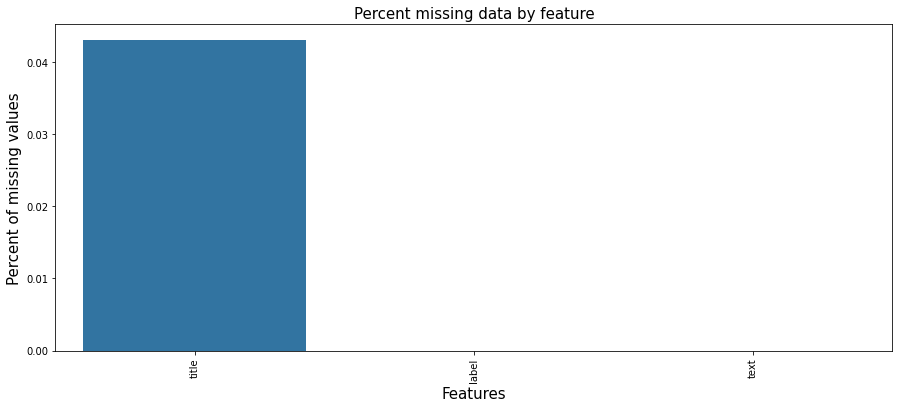

In [5]:
#Visualize the proportion of missing values

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')

sns.barplot(x=missing_data.index, y=missing_data['Percent'])

plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

missing_data.head()

In [6]:
target = data.label
labels = []
for item in target:
    if item not in labels:
          labels.append(item) 
    else:
            continue

In [7]:
num_labels = len(labels)
print(num_labels)

48


In [8]:
print(labels)

['app-development', 'apple', 'chemistry', 'edge-computing', 'blockchain', 'competitive-programming', 'cloud-computing', 'cyber-security', 'communication', 'computer-science', 'economics', 'artificial-intelligence', 'data-science', 'business', 'electronics', 'electrical', 'engineering-design', 'entrepreneurship', 'gaming', 'git', 'gitHub', 'google', 'graphic-design', 'history', 'internships', 'interview', 'iot', 'linguistics', 'literature', 'logic-design', 'machine-learning', 'management', 'marketing', 'mathematics', 'mechanical', 'mental-illness', 'operating-systems', 'physics', 'placement', 'political-science', 'reinforcement-learning', 'robotics', 'software', 'stock-exchange', 'vr', 'web-development', 'bitcoin', 'education']


In [9]:
for l in labels:
    data[l]=0

data.shape

(13294, 51)

In [10]:
for index, row in data.iterrows():
    for lx in labels:
        if lx in row['label']:
            data.at[index, lx] = 1

In [11]:
#Install bert and fastai

!pip install pytorch_pretrained_bert

!pip install https://github.com/fastai/fastai1/archive/master.zip

     |████████████████████████████████| 123 kB 421 kB/s 
     | 132.1 MB 1.1 MB/s
     |████████████████████████████████| 88 kB 363 kB/s 
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... - done
     |████████████████████████████████| 115 kB 1.3 MB/s 
  Created wheel for fastai: filename=fastai-1.0.64.dev0-py3-none-any.whl size=241880 sha256=3ae0a4f7a6f8e4e0f9b866b30742f917c1308ea997692eceb9a334eccec1f2fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wlanq3g/wheels/a9/1d/67/48a06642ed4ac8db07b364643d67755fc669efb970b683daa9
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp37-cp37m-linux_x86_64.whl size=334946 sha256=7f5cf952777e5dcd4226dc5cfbb5551531346be309999b8fa16b560453e7b6e2
  Stored in directory: /root/.cache/pip/wheels/87/85/9c/a325c89ff0498660ef8a335fb4b3912939c273ea4f094af29f
Successfully built fastai bottleneck
  Attempting uninstall: fastai
    Found e

In [12]:
#Import libraries

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks import SaveModelCallback

In [13]:
#Define constants

max_lr = 3e-5
epochs = 4
batch_size = 4
max_seq_len = 512

target_col = "text"
bert_model_name = "bert-base-uncased"
bert_model_path = "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt"

In [14]:
#Download the pre-trained model

from pytorch_pretrained_bert import BertTokenizer

bert_tok = BertTokenizer.from_pretrained(bert_model_path)

100%|██████████| 231508/231508 [00:00<00:00, 322696.24B/s]


In [15]:
class FastAiBertTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: BertTokenizer, max_seq_len, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        
        # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [16]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, 
                                                          max_seq_len=max_seq_len), 
                                                          pre_rules=[], 
                                                          post_rules=[])

In [17]:
#Construct a fastai Vocab object to use for preprocessing

fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [18]:
#Split the data into train and val

from sklearn.model_selection import train_test_split

train, val = train_test_split(data)

In [19]:
databunch = TextDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols=target_col,
                  label_cols=labels,
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

/opt/conda/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [20]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels = num_labels)

#print(bert_model)

100%|██████████| 407873900/407873900 [00:32<00:00, 12466683.08B/s]


In [21]:
loss_func = nn.BCEWithLogitsLoss()

In [22]:
learner = Learner(
    databunch, 
    bert_model,
    loss_func=loss_func,
    model_dir='.', 
    metrics=fbeta, 
  )

In [23]:
learner.fit_one_cycle(epochs, max_lr=max_lr)

epoch,train_loss,valid_loss,fbeta,time
0,0.063175,0.060098,0.541316,13:18
1,0.041701,0.041631,0.651638,13:24
2,0.033534,0.036965,0.716820,13:25
3,0.027195,0.035796,0.721046,13:11


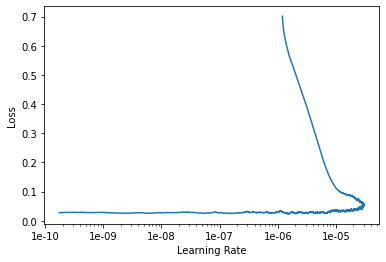

In [24]:
learner.save('model')

learner.recorder.plot()

In [25]:
def predict_tags(inp_txt):
    print("\nTags:",learner.predict(inp_txt)[0],"\n")

In [26]:
print(data['label'].value_counts())

business                   1316
blockchain                 1002
machine-learning            975
education                   967
data-science                953
marketing                   879
entrepreneurship            840
bitcoin                     701
artificial-intelligence     675
history                     657
web-development             561
gaming                      335
economics                   288
google                      265
computer-science            203
apple                       202
interview                   198
cyber-security              191
communication               189
management                  164
software                    147
gitHub                      126
literature                  123
mathematics                 116
git                         102
cloud-computing              98
internships                  82
iot                          78
mental-illness               71
edge-computing               63
physics                      61
electric

In [27]:
test_data=data.sample(100)
sum=0
for index, row in test_data.iterrows():
    prediction=learner.predict(row['text'])[0]
    print(prediction, "                 ",row['label'])


/opt/conda/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


interview                   interview
history                   history
business                   business
cyber-security                   cyber-security
                   software
business                   business
blockchain                   blockchain
history                   history
business                   business
                   electrical
google                   google
bitcoin                   bitcoin
marketing                   google
marketing                   marketing
history                   history
artificial-intelligence                   data-science
cyber-security                   cyber-security
blockchain                   blockchain
business                   business
data-science                   education
machine-learning                   machine-learning
                   robotics
gaming                   gaming
economics                   economics
computer-science                   competitive-programming
web-development                   web-